# Tracking Time Zero with CF3I Fluorescence

In [3]:
# Standard Packages
import numpy as np
from tifffile import tifffile as tf
import glob
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
from pybaselines import Baseline

## Goal: Read images quickly and identify a good way to find fluorescence

In [8]:
def get_image_details_fluor(file_names, sort=False):
    """
    Returns the data loaded from the tif files with a floor subtracted based on the median of the corner. Also returns arrays with the stage 
    positions, the file order number, and the number of counts per image.
    
    Arguments: 
    data_array (numpy.ndarray): Numpy data array containing the diffraction images.
    file_names = ['image001_10.tif', 'image002_20.tif', 'image004_40.tif', 'image003_30.tif', 'image004_40.tif']
    
    Returns:
    data_array (ndarray): Array of N x 1024 x 1024 where N is the length of tile file_names list. Generated by using tifffile as tf.
    stage_pos (array): Default. A numpy array containing the stage positions of the file. The index of each stage position corresponds to
                            the index of the file name in file_names.
    file_order (array): Returns the image number located in the file name. Reflects the order with which the images are taken. 
    counts(ndarray): One dimensional numpy array of length N containing the data after summing over each array element.

    """
    data_array = tf.imread(file_names) # construct array containing files
    data_array = np.nanmean(data_array, axis = 3)
    print(data_array.shape)
    
    try:
        stage_pos = []
        file_numbers = []
        try:
            #stage_pos = [np.float64(file_name[idx_start:idx_end]) for file_name in file_names]
            #stage_pos = np.array(stage_pos)
            for file in file_names:
                # string = list(map(str, file.split("/")))
                # stage_pos.append(float(string[-1][:-4]))
                # file_name = string[-2][-1]
                # file_name = file_name[:-4]
                # file_numbers.append(file_name)
                string = list(map(str, file.split("/")))
                stage_pos.append(float(string[-2]))
        except ValueError:
            raise ValueError("""Failed to convert a file name to a float. Make sure that index positions are correct for all files in file_names. 
            Also check separators""")
    except IndexError:
        raise ValueError("Invalid index values. Make sure the index values are within the range of the file name strings.")
    
    stage_pos = np.array(stage_pos)
    file_numbers = np.array(file_numbers)
    
    if sort == True:
        idx_sort = np.argsort(file_numbers)
        file_numbers = file_numbers[idx_sort]
        data_array = data_array[idx_sort]
        stage_pos = stage_pos[idx_sort]
    
    return data_array, stage_pos, file_numbers

def get_counts(data_array, plot = False):
    """
    Generates the counts from the given data by summing over the array elements. Returns 2d array of the same dimension as the
    input images.
    
    Arguments:
    
    data_array (numpy.ndarray): Numpy data array containing the diffraction images.
    plot (bool, optional): If set to true, generates a graph of the counts data.
    
    Returns:
    counts (numpy.ndarray): One dimensional numpy array containing the data after summing over each array element.
    
    Example:
    
    data = np.array([[[1, 2, 3], [4, 5, 6]], [[7, 8, 9], [10, 11, 12]]])
    >>>countData(data)
        array([21, 51])
    """
    counts = np.sum(data_array, axis = (1,2))
    if len(data_array) == 0:
        raise ValueError("Input data_array is empty.")
    if data_array.ndim != 3:
        raise ValueError("Input data_array is not 3 dimensional.")
    if plot == True:
        plt.plot(np.arange(len(data_array[:, 0, 0])), counts)
        plt.show()
    return counts

def get_image_details(file_names, sort=True):
    """
    Returns the data loaded from the tif files with a floor subtracted based on the median of the corner. Also returns arrays with the stage 
    positions, the file order number, and the number of counts per image.
    
    Arguments: 
    data_array (numpy.ndarray): Numpy data array containing the diffraction images.
    file_names = ['image001_10.tif', 'image002_20.tif', 'image004_40.tif', 'image003_30.tif', 'image004_40.tif']
    
    Returns:
    data_array (ndarray): Array of N x 1024 x 1024 where N is the length of tile file_names list. Generated by using tifffile as tf.
    stage_pos (array): Default. A numpy array containing the stage positions of the file. The index of each stage position corresponds to
                            the index of the file name in file_names.
    file_order (array): Returns the image number located in the file name. Reflects the order with which the images are taken. 
    counts(ndarray): One dimensional numpy array of length N containing the data after summing over each array element.

    """
    data_array = tf.imread(file_names) # construct array containing files
    
    try:
        stage_pos = []
        file_order = []
        try:
            #stage_pos = [np.float64(file_name[idx_start:idx_end]) for file_name in file_names]
            #stage_pos = np.array(stage_pos)
            for file in file_names:
                string = list(map(str, file.split("/")))
                folder_number = string[9][-3:]
                string = list(map(str, string[-1].split("-")))
                file_number = int(folder_number + string[1])
                file_order.append(int(file_number))
                string = list(map(str, string[-1].split("_")))
                stage_pos.append(float(string[0]))
        except ValueError:
            raise ValueError("""Failed to convert a file name to a float. Make sure that index positions are correct for all files in file_names. 
            Also check separators""")
    except IndexError:
        raise ValueError("Invalid index values. Make sure the index values are within the range of the file name strings.")
    
    stage_pos = np.array(stage_pos)
    file_order = np.array(file_order)
    counts = get_counts(data_array)
    
    if sort == True:
        idx_sort = np.argsort(file_order)
        file_order = file_order[idx_sort]
        data_array = data_array[idx_sort]
        stage_pos = stage_pos[idx_sort]
        counts = counts[idx_sort]
    
    return data_array, stage_pos, file_order, counts 

In [10]:
dataPath = '/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180822/T-zero/20180822_2314/'
#dataPath ='/home/centurion/lheald2/GUED_Analysis/GUED_Analysis/data_files/Fluorescence_Data/01102024/fluorescence/scan2/'
runPath = "/*/*/ANDOR1*.tif"

newPath = dataPath + runPath
print(newPath)

files = glob.glob(newPath) 
print(len(files))
data, stage_pos, file_names, counts = get_image_details(files[:])

/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180822/T-zero/20180822_2314//*/*/ANDOR1*.tif
559


In [19]:
ir_path = '/home/centurion/lheald2/GUED_Analysis/GUED_Analysis/data_files/Fluorescence_Data/01112024/ir_only/40d/*.tif'
uv_path = '/home/centurion/lheald2/GUED_Analysis/GUED_Analysis/data_files/Fluorescence_Data/01112024/uv_only/50d/*.tif'

# ir_path = '/home/centurion/lheald2/01102024/fluorescence/ir_only/*.tif'
# uv_path = '/home/centurion/lheald2/01102024/fluorescence/uv_only/*.tif'

ir_files = glob.glob(ir_path)
uv_files = glob.glob(uv_path)

ir_data = tf.imread(ir_files)
uv_data = tf.imread(uv_files)
ir_data = np.nanmean(ir_data, axis=3)
uv_data = np.nanmean(uv_data, axis=3)
ir_data = np.nanmean(ir_data, axis=0)
uv_data = np.nanmean(uv_data, axis=0)
print(ir_data.shape)
print(uv_data.shape)

(1024, 1280)
(1024, 1280)


In [12]:
test=tf.imread(files[0]);

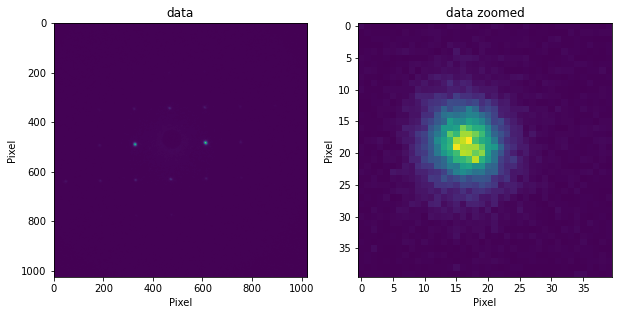

In [18]:
v_range = np.arange(340, 360, 1)
h_range = np.arange(800, 820, 1)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(test)
plt.xlabel('Pixel');
plt.ylabel('Pixel');
plt.title('data')

plt.subplot(1,2,2)
plt.imshow(test[470:510, 310:350]);
plt.xlabel('Pixel');
plt.ylabel('Pixel');
plt.title('data zoomed')
plt.show()

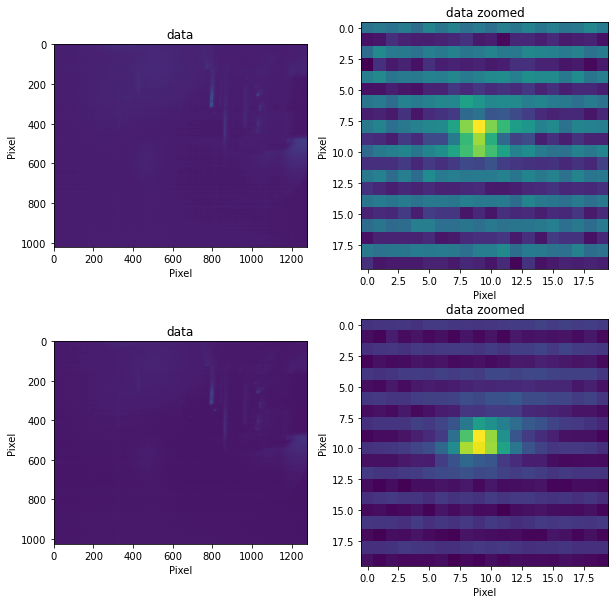

In [20]:
#345:355, 800:825

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(ir_data)
plt.xlabel('Pixel');
plt.ylabel('Pixel');
plt.title('data')

plt.subplot(2,2,2)
plt.imshow(ir_data[340:360, 800:820]);
plt.xlabel('Pixel');
plt.ylabel('Pixel');
plt.title('data zoomed')

plt.subplot(2,2,3)
plt.imshow(uv_data)
plt.xlabel('Pixel');
plt.ylabel('Pixel');
plt.title('data')

plt.subplot(2,2,4)
plt.imshow(uv_data[340:360, 800:820]);
plt.xlabel('Pixel');
plt.ylabel('Pixel');
plt.title('data zoomed')
plt.show()

## Trim Data

In [21]:
zoomed_data = data[:, 470:510, 310:350]
zoomed_ir = ir_data[340:360, 800:820]
zoomed_uv = uv_data[340:360, 800:820]

print(zoomed_data.shape)
lineout = np.mean(zoomed_data, axis = 1)
lineout_ir = np.mean(zoomed_ir, axis=0)
lineout_uv = np.mean(zoomed_uv, axis=0)
print(lineout.shape)
print(lineout_ir.shape)
print(lineout_uv.shape)

corrected_lineout = []
for image in lineout:
    baseline = image[0]
    baseline_sub = image-baseline
    corrected_lineout.append(baseline_sub)
    
corrected_lineout = np.array(corrected_lineout)

(559, 40, 40)
(559, 40)
(20,)
(20,)


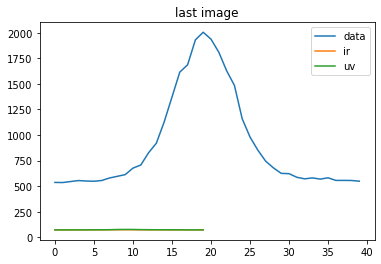

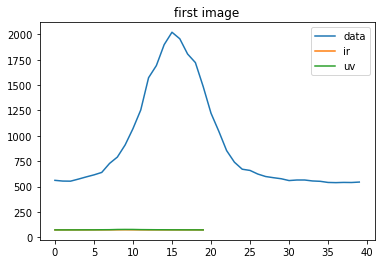

In [22]:
plt.figure()
plt.plot(lineout[-1], label="data")
plt.plot(lineout_ir, label="ir")
plt.plot(lineout_uv, label="uv")
plt.title("last image")
plt.legend()
plt.show()

plt.figure()
plt.plot(lineout[0], label="data")
plt.plot(lineout_ir, label="ir")
plt.plot(lineout_uv, label="uv")
plt.title("first image")
plt.legend()
plt.show()

## Average Based on Stage

In [23]:
uni_stage = np.round(np.unique(stage_pos), decimals=4)
print(uni_stage)
stage_len = len(uni_stage) #  Number of delays
print(stage_len)

ave_data = []

for i in range(stage_len):
    stage_ave = np.mean(lineout[np.where(stage_pos==uni_stage[i])[0]], axis = 0);
    ave_data.append(stage_ave)
    
ave_data = np.array(ave_data)
print(ave_data.shape)

[108.9  108.93 108.96 108.99 109.02 109.05 109.08 109.11 109.14 109.17]
10
(10, 40)


## Get Results

In [27]:
current_ave = np.loadtxt('/home/centurion/lheald2/GUED_Analysis/GUED_Analysis/data_files/Fluorescence_Data/current_ave.txt')
current_ave

array([-15.49 , -15.536, -15.752, -16.604, -16.788, -16.844, -17.146,
       -17.36 , -17.45 , -17.616, -17.696, -17.886, -18.096, -18.624,
       -19.44 , -20.062, -21.034, -23.024, -24.37 , -26.306, -28.742,
       -30.552, -33.044, -33.956, -33.692, -32.902, -28.836, -25.25 ,
       -23.084, -21.724, -19.976, -18.818, -18.042, -17.388, -17.082,
       -16.7  , -16.556, -16.314, -16.036, -16.15 , -16.278, -15.974,
       -16.172, -16.236, -16.122, -16.186, -16.06 , -16.192, -16.212,
       -15.936, -16.236, -16.066, -16.248, -15.978, -16.098, -16.032,
       -16.068, -15.944, -15.876, -15.99 , -15.81 , -15.638, -15.566,
       -15.712, -15.664, -15.554, -15.51 , -15.376, -15.542, -15.556,
       -15.486, -15.282, -15.38 , -15.462, -15.346, -15.376, -15.31 ,
       -15.258, -15.298, -15.298, -15.454, -15.248, -15.348, -15.296,
       -15.368, -15.172, -15.324, -15.26 , -15.238, -15.038, -15.098,
       -15.248, -15.07 , -15.388, -15.156, -15.332, -15.324, -15.32 ,
       -15.422, -15.

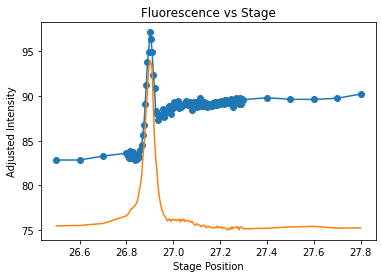

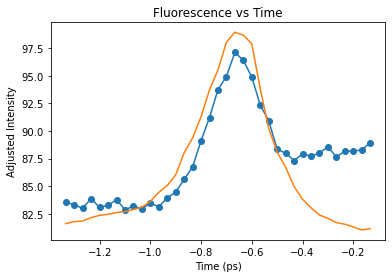

In [39]:
sum_data = np.sum(ave_data, axis=1)
max_data = np.max(ave_data, axis=1)
plt.figure()
plt.plot(uni_stage, max_data, "-o")
plt.plot(uni_stage, -current_ave+60)
#plt.axhline(y = min_value, color = 'r', linestyle = '-',linewidth=1);
#plt.axhline(y = max_value, color = 'r', linestyle = '-',linewidth=1);
plt.title("Fluorescence vs Stage")
plt.xlabel("Stage Position")
plt.ylabel("Adjusted Intensity")
plt.show()

realtime = (uni_stage-27)/0.15  # Delay axis in ps

plt.figure()
plt.plot(realtime[3:40], max_data[3:40], "-o")
plt.plot(realtime[3:40], -current_ave[3:40]+65)
plt.title("Fluorescence vs Time")
plt.xlabel("Time (ps)")
plt.ylabel("Adjusted Intensity")
plt.show()

## Normalizing

In [33]:
min_value = 0
#min_value = np.max(lineout_ir)
max_value = np.max(lineout_uv)
print(min_value, max_value)

def normalize(data, min_value, max_value):
    norm_data = (data-min_value)/(max_value-min_value)
    return norm_data

norm_data = normalize(max_data, min_value, max_value)

0 77.9925


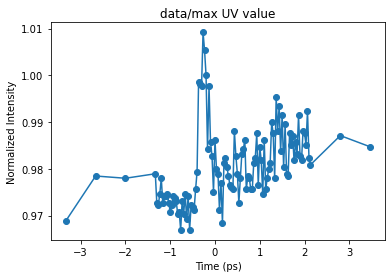

In [141]:
plt.figure()
plt.plot(realtime[:], norm_data[:], "-o")
plt.xlabel("Time (ps)")
plt.ylabel("Normalized Intensity")
plt.title("data/max UV value")
#plt.ylim(0, 1)
plt.show()

## Fitting

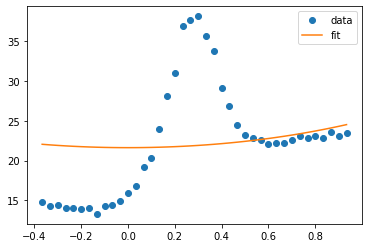

In [146]:
xdata = realtime[20:60]
ydata = max_data[20:60]

def Gauss(x, A, B): 
    y = A*np.exp(-1*B*x**2) 
    return y 
parameters, covariance = curve_fit(Gauss, xdata, ydata) 
  
fit_A = parameters[0] 
fit_B = parameters[1] 
  
fit_y = Gauss(xdata, fit_A, fit_B) 
plt.plot(xdata, ydata, 'o', label='data') 
plt.plot(xdata, fit_y, '-', label='fit') 
plt.legend()

## Original Data

In [29]:
stage = [
    1.10, 1.000, 0.997, 0.994, 0.991, 0.988, 0.985, 0.982, 0.979, 0.976, 0.973, 0.970, 0.967, 0.964, 0.961, 0.958, 0.955, 0.952, 0.949, 0.946, 0.943, 
    0.940, 0.937, 0.934, 0.931, 0.928, 0.925, 0.922, 0.919, 0.916, 0.913, 0.910, 0.907, 0.904, 0.901, 0.898, 0.798, 0.748, 0.698]
stage = np.array(stage)+26
intensity = [ 
     140, 130, 130, 125, 125, 120, 120, 125, 125, 130, 140, 140, 140, 140, 140, 135, 130, 115, 110, 100, 95, 90, 90, 88, 85, 85, 85, 80, 80, 80, 80,
    80, 85, 85, 90, 85, 90, 90, 90]
time = np.array(stage)/0.15        

In [30]:
print(len(intensity))
print(len(stage))
print(time)

39
39
[180.66666667 180.         179.98       179.96       179.94
 179.92       179.9        179.88       179.86       179.84
 179.82       179.8        179.78       179.76       179.74
 179.72       179.7        179.68       179.66       179.64
 179.62       179.6        179.58       179.56       179.54
 179.52       179.5        179.48       179.46       179.44
 179.42       179.4        179.38       179.36       179.34
 179.32       178.65333333 178.32       177.98666667]


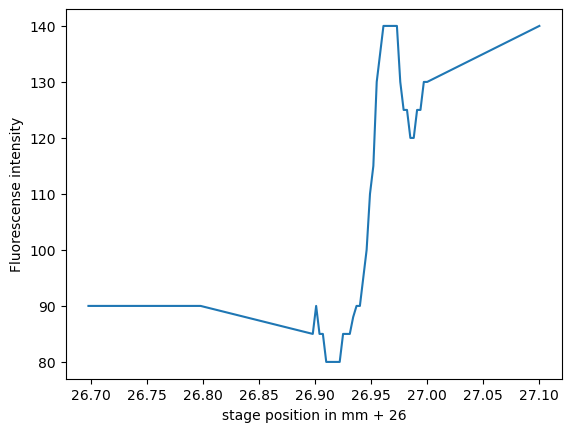

In [31]:
plt.figure()
plt.plot(stage, intensity)
plt.xlabel("stage position in mm + 26")
plt.ylabel("Fluorescense intensity")
plt.show()

Fit parameters: 
t_0 = 26.9482  mm +-  0.0011  mm
FWHM =  0.0131 mm +- 0.0035 mm




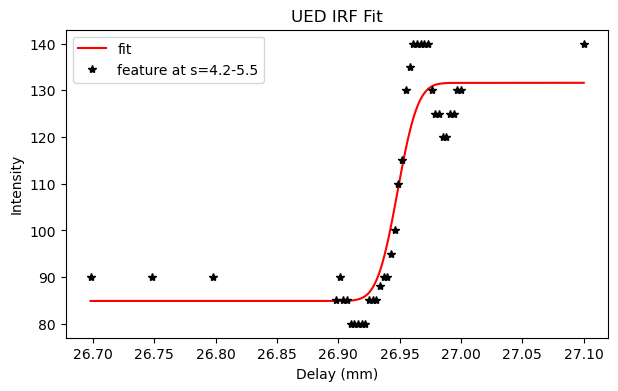

In [34]:
A = 150
t0 = 26.9
sigma = 0.1
offset = 90
x0 = [A, t0, sigma,offset]
# ## when fitting with an error function
import scipy
def equations(t, A, t0, sigma, offset): #def equations
    fit = A*(scipy.special.erf((t-t0)/(np.sqrt(2)*sigma)))+offset
    return fit

def erf_fit(t, A, t0, sigma, offset):
    fit = A* scipy.special.erf(((t-t0)/(sigma/(np.sqrt(2*np.log(2)))))*np.sqrt(2))+offset
    return fit 

# yo = equations(t, A, t0, sigma, offset) #equations
popt, pcov, info, _, _ = curve_fit(erf_fit, stage[:38], intensity[:38], p0 = x0, maxfev = 5000000, method='lm',full_output=True)
fit_new = np.linspace(stage[0],stage[-1],1000)
## error func fit
A, t0, sigma, offset = popt
print("Fit parameters: ")
print("=====================================================")

print("t_0 =", '%1.4f '%(popt[1]),'mm +- ','%1.4f '%np.sqrt(pcov[1,1]),"mm")
print("FWHM = ", '%1.4f'%(popt[2]), 'mm +-', '%1.4f' %np.sqrt(pcov[2,2]), "mm")

print("\n")
y_new = equations(fit_new, *popt)
plt.figure(figsize=(7,4))
# plt.plot(t,yo,color=‘purple’,ls=‘--’)
plt.plot(fit_new,y_new,color='red', label="fit")
plt.plot(stage, intensity,'*',color='black', label="feature at s=4.2-5.5")
#plt.xlim(-1,3)
plt.xlabel("Delay (mm)")
plt.ylabel("Intensity")
plt.title("UED IRF Fit")
plt.legend()
plt.show()

## MISC

In [ ]:
uv_first = [76, 81, 83, 83]
peak = [79, 93, 99, 99] 
ir_first = [77, 89, 89, 89]